## 7. Data Quality

In [ ]:
import pandas as pd

def gd_path(file_id):
    """Generate a shareable link from Google Drive file id."""
    return f"https://drive.google.com/uc?export=download&id={file_id}"

# Google Drive file ids
file_ids = {
    "brands": "14_RkEUuhf9-otJqbVITDTvus45zR8LJp",
    "orderlines": "18Tzi4SxwYsijRdhvUQUGSdi0A2WzlzA9",
    "orders": "14HwyeNbaWy8IZ9BkwbDSxfDURHUtJzJ7",
    "products": "1Rpo8POQKb_rWvWQczlyOJOqIZgmZSRjD",
}

# Read data from Google Drive
brands_cl = pd.read_csv(gd_path(file_ids["brands"]), sep=",")
orderlines_cl = pd.read_csv(gd_path(file_ids["orderlines"]), sep=",", parse_dates=["date"])
orders_cl = pd.read_csv(gd_path(file_ids["orders"]), sep=",", parse_dates=["created_date"])
products_cl = pd.read_csv(gd_path(file_ids["products"]), sep=",")

---
<font color="red"> The code below will create copies of each of the clean datasets:
* `brands_cl` --> `brands_df`
* `orderlines_cl` --> `orderlines_df`
* `orders_cl` --> `orders_df`
* `products_cl` --> `products_df`
---

In [ ]:
brands_df = brands_cl.copy()
orderlines_df = orderlines_cl.copy()
orders_df = orders_cl.copy()
products_df = products_cl.copy()

### 7.1. Define Pandas display format

In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# sets the number of digits after the decimal point to 2
pd.set_option('display.max_rows', 1000)
# sets the max rows to be displayed to 1.000

### 7.2. Exclude unwanted orders

In [ ]:
orders_df.info()

In [ ]:
orders_df["state"].unique()

Only keep `"Completed"`

In [ ]:
# we only keep orders with the status of "Completed" and save it in `orders_comp_df`
orders_completed_df = orders_df.loc[orders_df["state"].isin(["Completed"])]

In [ ]:
orders_completed_df.info()

In [ ]:
# we create a list of "order_id" for later reference
orders_completed_list = list(orders_comp_df["order_id"])

In [ ]:
# we update `orders_qu` in accordance with the list above
orders_qu = orders_df.loc[orders_cl["order_id"].isin(orders_completed_list), :].copy()

In [ ]:
orders_qu.info()

In [ ]:
# we update `orderlines_qu` in accordance with the list above
orderlines_qu = orderlines_df.loc[orderlines_cl["id_order"].isin(orders_completed_list), :].copy()

In [ ]:
orderlines_qu.info()

Only keep orders that are present in both `orders` and `orderlines`

In [ ]:
# counts the unique "order_id"s
orders_qu.order_id.nunique()
# should be 46605

In [ ]:
# counts the unique "id_order"s
orderlines_qu.id_order.nunique()
# should be 43064

In [ ]:
# inner merge of orderlines_qu and orders_qu
orders_orderlines_qu_merged = orders_qu.merge(
    orderlines_qu,
    how="inner",
    left_on="order_id",
    right_on="id_order"
)

In [ ]:
# create a list of the matching "order_id"s and "id_order"s
order_ids_in_both_list = list(orders_orderlines_qu_merged["order_id"].unique())

In [ ]:
order_ids_in_both_list

In [ ]:
# we update `orderlines_qu` in accordance with the list above
orderlines_qu = orderlines_qu.loc[orderlines_qu["id_order"].isin(order_ids_in_both_list), :].copy()

In [ ]:
# we update `orders_qu` in accordance with the list above
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(order_ids_in_both_list), :].copy()

In [ ]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))
# should be (43064, 43064)

(43064, 43064)

### 7.3. Exclude orders with unknown products


In [ ]:
# make a list of known sku from `products_cl`
known_sku_list = list(products_cl["sku"])

In [ ]:
orderlines_qu.sku.isin(known_sku_list).value_counts()
# should be 55304 True and 1410 False

From `orderlines_qu` we're going to create a list of order_ids that are of unknown products. Products are unknown because we previously cleaned them out from the `products_df` on the way to `products_cl`.

In [ ]:
orders_unknown_products_list = list(orderlines_qu.loc[~orderlines_qu.sku.isin(known_sku_list), "id_order"])

Clear `orders_qu` and `orderlines_qu` of unknown products

In [ ]:
orders_qu = orders_qu.loc[~orders_qu["order_id"].isin(orders_unknown_products_list), :].copy()
orderlines_qu = orderlines_qu.loc[~orderlines_qu["id_order"].isin(orders_unknown_products_list), :].copy()

In [ ]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))
# should be (41685, 41685)

### 7.4. Explore the revenue from different tables

In [ ]:
orderlines_qu_copy = orderlines_qu.copy()

In [ ]:
orderlines_qu.info()

Step 1: Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [ ]:
orderlines_qu_copy["unit_price_total"] = orderlines_qu_copy["unit_price"] * orderlines_qu_copy["product_quantity"]

Step 2: Group by `order_id`, summarising by the sum of `unit_price_total`

In [ ]:
orderlines_qu_group_order_df = orderlines_qu_copy.groupby("id_order", as_index=False)["unit_price_total"].sum()

In [ ]:
orderlines_qu_group_order_df

### 7.5. What is the average difference between `total_paid` and `unit_price_total`?

In [ ]:
orders_qu_copy = orders_qu.copy()

Let's merge our grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [ ]:
diff_df = orders_qu_copy
# inner merge of orderlines_qu and orders_qu
diff_df = orders_qu_copy.merge(
    orderlines_qu_group_order_df,
    left_on="order_id",
    right_on="id_order"
)

In [ ]:
diff_df.info()

In [ ]:
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]

In [ ]:
diff_df.head()

What is the distribution of these differences?

In [ ]:
diff_df["difference"].mean().round(2)
# should be 4.48

Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

In [ ]:
diff_df["difference"].hist(bins= 50, figsize=(8,6));

In [ ]:
diff_df["difference"].describe()

In [ ]:
diff_df.sort_values("difference", ascending=False)
# some differences can be seen as shipping costs but others habe a huge difference. Both very high or very low

If there are differences that you can’t explain: what should you do with these orders?

In [ ]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

# calculate the interquartile range
IQR = Q3-Q1

# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[(diff_df["difference"] >= (Q1 - 1.5*IQR)) & (diff_df["difference"] <= (Q3 + 1.5*IQR)), :]

In [ ]:
diff_no_outliers_df.difference.hist(bins= 50, figsize=(8,6));
# the outliers are deleted and the distribution is closer together

In [ ]:
normal_diff_list = list(diff_no_outliers_df["order_id"])
# the orders I just deleted also need to be deleted in the other tables.
# This will create a list with all ids that are left (without outliers)

In [ ]:
orders_df = orders_df.loc[orders_df["order_id"].isin(normal_diff_list), :]
orderlines_df = orderlines_cl.loc[orderlines_cl["id_order"].isin(normal_diff_list), :]
# these lines will compare in both tables the Ids that are in the
# normal_diff_list and the table and will only keep the matching ones.

In [ ]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))
# both tables have the same amount of order_ids
# should be (41685, 41685)

Do not forget to download your quality controlled DataFrames

In [ ]:
orderlines_qu.info()

In [ ]:
orders_qu.info()

In [ ]:
from google.colab import files

orders_qu.to_csv("orders_qu.csv", index=False)
files.download("orders_qu.csv")

orderlines_qu.to_csv("orderlines_qu.csv", index=False)
files.download("orderlines_qu.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
### Importing quality checked data and creating new DataFrames

In [ ]:
import pandas as pd

def gd_path(file_id):
    """Generate a shareable link from Google Drive file id."""
    return f"https://drive.google.com/uc?export=download&id={file_id}"

# Google Drive file ids
file_ids = {
    "brands": "1rGaU7M127HRCiBzw41Rv_SwZByHafT86",
    "orderlines": "1dAhM7ScbCGwLWkmBRhoEw2OUL6rkzxpF",
    "orders": "16acxvtxHTaZdwLqIpBA52tCJ1PAF80Rb",
    "products": "1Q4NLNKEzVoSAwPq8OFOSZyfwLIXnJTen",
}

# Read data from Google Drive
brands_qu = pd.read_csv(gd_path(file_ids["brands"]), sep=",")
orderlines_qu = pd.read_csv(gd_path(file_ids["orderlines"]), sep=",", parse_dates=["date"])
orders_qu = pd.read_csv(gd_path(file_ids["orders"]), sep=",", parse_dates=["created_date"])
products_qu = pd.read_csv(gd_path(file_ids["products"]), sep=",")

<font color="red"> The code below will create copies of each of the quality checked datasets:
* `brands_qu` --> `brands_df`
* `orderlines_qu` --> `orderlines_df`
* `orders_qu` --> `orders_df`
* `products_qu` --> `products_df`

In [ ]:
# this will create copy of the data cleaned and quality checked datasets
brands_df = brands_qu.copy()
orderlines_df = orderlines_qu.copy()
orders_df = orders_qu.copy()
products_df = products_qu.copy()

In [ ]:
brands_df.info()

In [ ]:
orderlines_df.info()

In [ ]:
orders_df.info()

In [ ]:
products_df.info()

# 8. Data Analysis

### 8.1. What is the time period that the dataset covers?

In [ ]:
#What is the time period the dataset covers?

# Find the minimum and maximum dates in the dataset
start_date = orders_df['created_date'].min()
end_date = orders_df['created_date'].max()

# Print the time period covered by the dataset
print("Time period covered by the dataset:")
print("Start date:", start_date)
print("End date:", end_date)

Time period covered by the dataset:
Start date: 2017-01-01 01:51:47
End date: 2018-03-14 12:03:52


### 8.2. What is the overall revenue for that time?

In [ ]:
#What is the overall revenue for that time?

# Filter the 'orders_df' based on the time period covered by the dataset
filtered_orders = orders_df[(orders_df['created_date'] >= start_date) & (orders_df['created_date'] <= end_date)]

# Calculate the overall revenue
overall_revenue = filtered_orders['total_paid'].sum()

# Print the overall revenue
print("Overall revenue for the time period:")
print(overall_revenue)


Overall revenue for the time period:
8158224.15


### 8.3. Are there seasonal patterns in the evolution of sales?

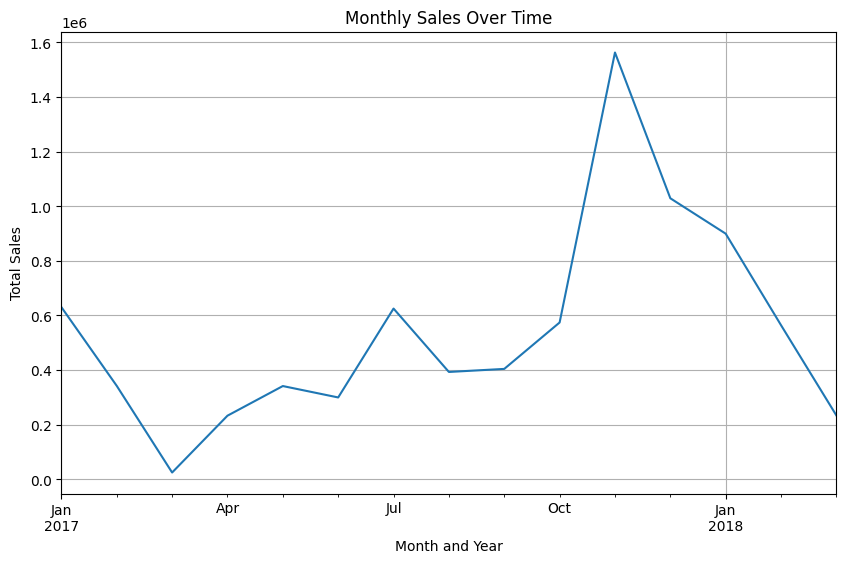

In [ ]:
#Are there seasonal patterns in the evolution of sales?

import matplotlib.pyplot as plt

# Extract the month and year from the 'created_date' column
orders_df['month_year'] = orders_df['created_date'].dt.to_period('M')

# Group the data by month and calculate the total sales for each month
monthly_sales = orders_df.groupby('month_year')['total_paid'].sum()

# Plot the monthly sales
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line')
plt.xlabel('Month and Year')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Over Time')
plt.grid(True)
plt.show()

### 8.4. What are the most sold products?

In [ ]:
#What are the most sold products?

# merge table
merged_df = pd.merge(orderlines_cl, products_cl, on='sku')

# Group the data by product name and calculate the total quantity sold for each product
product_sales = merged_df.groupby('name')['product_quantity'].sum()

# Sort the products by the total quantity sold in descending order
top_sold_products = product_sales.sort_values(ascending=False)

# Print the top sold products
print("Top sold products:")
print(top_sold_products.head(10))


Top sold products:
name
IPhone AppleCare Protection Plan                                        5576
Apple Lightning Cable Connector to USB 1m White (OEM)                   2337
Red 4TB WD 35 "Mac PC hard drive and NAS                                1828
AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch    1663
EarPods Apple Headphones with Remote and Mic (OEM)                      1618
Samsung 850 EVO SSD Disk 500GB                                          1346
Apple iPhone 32GB Space Gray                                            1182
Apple Pencil                                                            1131
Crucial MX300 525GB SSD Disk                                            1122
WD Red 3TB 35 "Mac PC hard drive and NAS                                1048
Name: product_quantity, dtype: int64


### 8.5. What are the products that generate the most revenue?

In [ ]:
#What are the products that generate the most revenue?

merged_order_orderlines_df = pd.merge(orders_cl, orderlines_cl, left_on='order_id', right_on='id_order', how='inner')
merged_product_df = pd.merge(merged_order_orderlines_df, products_cl, on='sku')

# Group the data by product name and calculate the total revenue generated for each product
product_revenue = merged_product_df.groupby('name')['total_paid'].sum()

# Sort the products by the total revenue generated in descending order
top_revenue_products = product_revenue.sort_values(ascending=False)

# Print the products that generate the most revenue
print("Products generating the most revenue:")
print(top_revenue_products.head(10))

Products generating the most revenue:
name
IPhone AppleCare Protection Plan                            1712284.39
Apple Pencil                                                 847625.56
Apple iPhone 8 Plus 64GB Gold                                805341.92
Apple iPhone 64GB Space Gray 8                               647000.07
Apple iPhone 8 Plus 64GB Space Gray                          598453.19
IPad AppleCare Protection Plan                               530306.76
Apple MacBook Air 13 "Core i5 18GHz | 8GB RAM | 128GB SSD    499754.82
Red 4TB WD 35 "Mac PC hard drive and NAS                     495987.76
Apple iPhone 32GB Space Gray                                 458195.22
Wireless Headset iFrogz zagg Coda microphone                 449570.61
Name: total_paid, dtype: float64
